<a href="https://colab.research.google.com/github/RuksatKhanShayoni/DeepLearning-CS898AB-/blob/Assignment4-Ques2-AutoEncoderDecoder_DenoisingDocument/Assignment4_Ques2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip "/content/sampleSubmission.csv.zip" -d /content/
!unzip "/content/test.zip" -d /content/
!unzip "/content/train.zip" -d /content/
!unzip "/content/train_cleaned.zip" -d /content/

Archive:  /content/sampleSubmission.csv.zip
  inflating: /content/sampleSubmission.csv  
Archive:  /content/test.zip
   creating: /content/test/
  inflating: /content/test/1.png     
 extracting: /content/test/10.png    
  inflating: /content/test/100.png   
 extracting: /content/test/103.png   
  inflating: /content/test/106.png   
 extracting: /content/test/109.png   
  inflating: /content/test/112.png   
 extracting: /content/test/115.png   
 extracting: /content/test/118.png   
  inflating: /content/test/121.png   
  inflating: /content/test/124.png   
  inflating: /content/test/127.png   
 extracting: /content/test/13.png    
  inflating: /content/test/130.png   
 extracting: /content/test/133.png   
  inflating: /content/test/136.png   
 extracting: /content/test/139.png   
 extracting: /content/test/142.png   
 extracting: /content/test/145.png   
  inflating: /content/test/148.png   
 extracting: /content/test/151.png   
  inflating: /content/test/154.png   
 extracting: /conte

In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

### **Preprocessing Dataset**

In [3]:
# load and preprocess noisy and clean image
def load_images(noisy_dir, clean_dir, img_size=(128, 128)):
    noisy_images = []   # list to store noisy images
    clean_images = []   # list to store clean images

    # iterate noisy folder
    for filename in sorted(os.listdir(noisy_dir)):
        # Read images in grayscale
        noisy_img = cv2.imread(os.path.join(noisy_dir, filename), cv2.IMREAD_GRAYSCALE)
        clean_img = cv2.imread(os.path.join(clean_dir, filename), cv2.IMREAD_GRAYSCALE)

        # if both images are successfully loaded
        if noisy_img is not None and clean_img is not None:
            # resize image to 128x128
            noisy_img = cv2.resize(noisy_img, img_size) / 255.0  # Normalize to [0, 1]
            clean_img = cv2.resize(clean_img, img_size) / 255.0  # Normalize to [0, 1]

            # add the preprocessed images to the list
            noisy_images.append(noisy_img)
            clean_images.append(clean_img)

    # convert lists to NumPy arrays
    noisy_images = np.array(noisy_images).reshape(-1, img_size[0], img_size[1], 1)
    clean_images = np.array(clean_images).reshape(-1, img_size[0], img_size[1], 1)

    return noisy_images, clean_images

# path of noisy and clean images
noisy_path = '/content/train'
clean_path = '/content/train_cleaned'

# load all images
noisy_imgs, clean_imgs = load_images(noisy_path, clean_path)

#to report MSE & SSIM need known clean targets. So,
# split dataset into training 80% and testing 20% set
X_train, X_test, y_train, y_test = train_test_split(noisy_imgs, clean_imgs, test_size=0.2, random_state=42)

# Print out the number of samples in training and test sets
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 115, Testing samples: 29


# **Model Architecture: AutoEncoder**

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

# input layer for 128x128 grayscale images
input_img = keras.Input(shape=(128, 128, 1))

# Encoder
# First Conv layer with 32 filters and 3x3 kernel
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)

# First Max Pooling layer downsamples to 64x64
x = layers.MaxPooling2D((2, 2), padding='same')(x)

# Second Max Pooling layer downsamples to 32x32
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
# First Conv layer after encoding 32 filters
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)

# Upsample to 64x64
x = layers.UpSampling2D((2, 2))(x)

# Another Conv layer to refine details
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# Upsample to 128x128
x = layers.UpSampling2D((2, 2))(x)

# Final layer: 1 filter, sigmoid to produce grayscale output in [0, 1]
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Define the model
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Print model summary (optional)
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,105 (74.63 KB)

 Trainable params: 19,105 (74.63 KB)

 Non-trainable params: 0 (0.00 B)

## **Train the Model**

In [5]:
# Train the model
history = autoencoder.fit(
    X_train, y_train,             # X_train: noisy, y_train: clean
    epochs=50,
    batch_size=8,
    shuffle=True,
    validation_data=(X_test, y_test)  # X_test: noisy, y_test: clean
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - loss: 0.4978 - val_loss: 0.3733
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3589 - val_loss: 0.3698
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3594 - val_loss: 0.3589
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3453 - val_loss: 0.3361
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3202 - val_loss: 0.3028
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2898 - val_loss: 0.2851
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2771 - val_loss: 0.2810
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2757 - val_loss: 0.2765
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2698 - val_loss: 0.2733
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2675 - val_loss: 0.2700
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2639 - val_loss: 0.2672
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2625 -

# **Evaluate the model**

In [7]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import pandas as pd

predicted = autoencoder.predict(X_test)

results = []

# iterate each image and calculate performance metrics
for i in range(len(X_test)):
    original = y_test[i].reshape(128, 128)        # Ground truth clean image
    reconstructed = predicted[i].reshape(128, 128)  # Model's denoised output

    # calculate MSE
    mse_val = np.mean((original - reconstructed) ** 2)

    # calculate SSIM
    ssim_val = ssim(original, reconstructed, data_range=1.0)

    # store result
    results.append({
        'Image Index': i + 1,
        'MSE': round(mse_val, 4),
        'SSIM': round(ssim_val, 4)
    })

# convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
    Image Index     MSE    SSIM
0             1  0.0275  0.5896
1             2  0.0391  0.5373
2             3  0.0331  0.5821
3             4  0.0270  0.6059
4             5  0.0395  0.5713
5             6  0.0455  0.5583
6             7  0.0314  0.5099
7             8  0.0403  0.6035
8             9  0.0424  0.5696
9            10  0.0367  0.5560
10           11  0.0389  0.5663
11           12  0.0340  0.5942
12           13  0.0286  0.6002
13           14  0.0312  0.5407
14           15  0.0294  0.5917
15           16  0.0415  0.5978
16           17  0.0357  0.5583
17           18  0.0338  0.5631
18           19  0.0322  0.5158
19           20  0.0220  0.6185
20           21  0.0456  0.5493
21           22  0.0265  0.5991
22           23  0.0254  0.5829
23           24  0.0262  0.5668
24           25  0.0390  0.5712
25           26  0.0289  0.5468
26           27  0.0453  0.5379
27           28  0.0445  0.5154
28           29  0.0337  0.5679


# **Plot Graph**

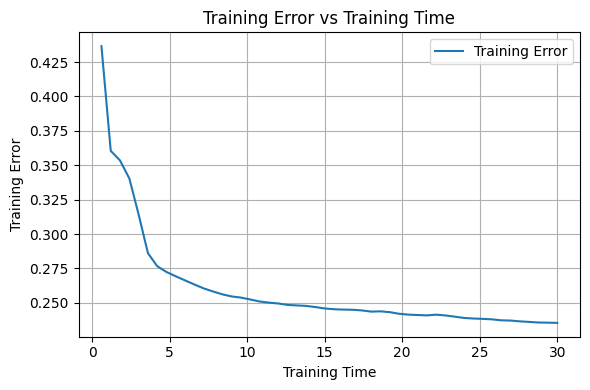

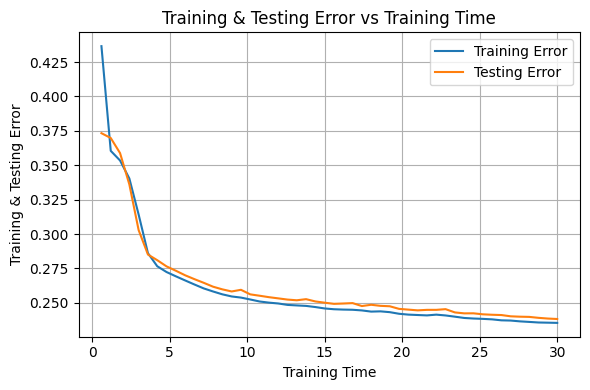

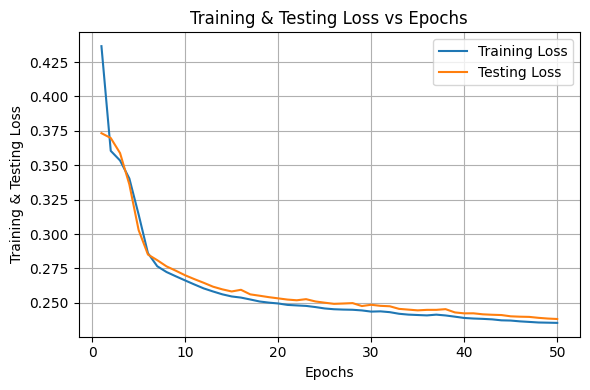

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# get loss and val_loss from training
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(1, len(train_loss) + 1)

# cumulative sum of training time
training_time = np.cumsum(np.ones_like(epochs) * 0.6)

# Graph 1: Training Error (y-axis) vs Training Time (x-axis)
plt.figure(figsize=(6, 4))
plt.plot(training_time, train_loss, label='Training Error')
plt.xlabel('Training Time')
plt.ylabel('Training Error')
plt.title('Training Error vs Training Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Graph 2: Training & Testing Error (y-axis) vs Training Time (x-axis)
plt.figure(figsize=(6, 4))
plt.plot(training_time, train_loss, label='Training Error')
plt.plot(training_time, val_loss, label='Testing Error')
plt.xlabel('Training Time')
plt.ylabel('Training & Testing Error')
plt.title('Training & Testing Error vs Training Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Graph 3: Training & Testing Loss (y-axis) vs Epochs (x-axis)
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Training & Testing Loss')
plt.title('Training & Testing Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()